### 导入数据，进行初步的EDA。

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



df = pd.read_csv('../data/Final_csv/result.csv')
#删除Unnamed: 0，Rank这两列
print(df.head())
df = df.drop(['Unnamed:_0','Rank'], axis=1)

   Unnamed:_0  Rank            NOC  Gold  Silver  Bronze  Total  Year  Host  \
0           0     1  United_States    11       7       2     20  1896     0   
1           1     2         Greece    10      18      19     47  1896     1   
2           2     3        Germany     6       5       2     13  1896     0   
3           3     4         France     5       4       2     11  1896     0   
4           4     5  Great_Britain     2       3       2      7  1896     0   

   Number_of_people  ...  Cycling_Mountain_Bike  3x3_Basketball  \
0                14  ...                      0               0   
1               101  ...                      0               0   
2                19  ...                      0               0   
3                12  ...                      0               0   
4                10  ...                      0               0   

   Cycling_BMX_Freestyle  Sport_Climbing  Marathon_Swimming,_Swimming  \
0                      0               0         

### 进行特征筛选与特征降维
- 首先分析变量与目标变量之间的相关性，然后分析变量与目标变量的互信息，综合考虑两者的结果，进行特征选择。
- 观察看有没有必要进行特征降维，如果有，可以考虑使用PCA等方法进行特征降维。

In [2]:
df.head()
target = ['Gold', 'Silver', 'Bronze','Total']
features = ['Rank', 'Host','Number_of_people']

# # 相关性分析
# corr = df[features+target].corr()
# plt.figure(figsize=(10, 10))
# sns.heatmap(corr, annot=True, cmap='coolwarm')
# plt.title('Correlation Matrix')
# plt.show()

    
# # 统计之前从来没有获得过奖牌的国家
medal_0_country = []
# for country in df['NOC'].unique():
#     country_df = df[df['NOC'] == country]
#     if country_df['Goden'].sum() == 0:
#         medal_0_country.append(country)
        
# print('The number of countries that have never won a medal:', len(medal_0_country))


df1 = pd.read_csv('../data/summerOly_athletes.csv')
#把Medal 这列的数据进行lable编码
df1['Medal'] = df1['Medal'].map({'Gold': 3, 'Silver': 2, 'Bronze': 1, 'No medal': 0})
for country in df1['NOC'].unique():
    country_df = df1[df1['NOC'] == country]
    #  观察Medal列，如果这个国家一直都是"no medal"，那么这个国家就是从来没有获得过奖牌的国家
    if country_df['Medal'].sum() == 0:
        medal_0_country.append(country)

        
        
print('The number of countries that have never won a medal:', len(medal_0_country))
print(medal_0_country)

    
    

The number of countries that have never won a medal: 77
['CHA', 'NCA', 'LBA', 'PLE', 'COM', 'BRU', 'MDV', 'YAR', 'CGO', 'BEN', 'SOM', 'MLI', 'ANG', 'BAN', 'ESA', 'HON', 'SEY', 'MTN', 'SKN', 'VIN', 'LBR', 'NEP', 'PLW', 'ASA', 'SAM', 'RWA', 'MLT', 'GUI', 'BIZ', 'YMD', 'SLE', 'PNG', 'YEM', 'OMA', 'VAN', 'IVB', 'CAF', 'MAD', 'MAL', 'BIH', 'GUM', 'CAY', 'GBS', 'TLS', 'COD', 'LAO', 'ROT', 'CAM', 'SOL', 'CRT', 'GEQ', 'BOL', 'SAA', 'ANT', 'AND', 'FSM', 'MYA', 'MAW', 'RHO', 'STP', 'LIE', 'GAM', 'COK', 'SWZ', 'NBO', 'ARU', 'NRU', 'VNM', 'BHU', 'MHL', 'KIR', 'UNK', 'TUV', 'NFL', 'SSD', 'LES', 'LBN']


### 接下来完成第一步也就是零膨胀模型的构建
- 首先判断历史数据的平稳性，使用Augmented Dickey-Fuller检验验证奖牌数时间序列的平稳性。
- 然后为第一部分（零膨胀逻辑回归）选择合适的特征，使用逻辑回归模型预测某国是否属于“永远无法获奖”的群体（结构性零值）。
- 对于第二部分（计数部分），如果数据不平稳就选择负二项分布，如果数据平稳就选择泊松分布。
- 最后，将两部分的结果相乘，得到最终的预测结果。


In [3]:
import statsmodels.api as sm
from statsmodels.discrete.count_model import ZeroInflatedNegativeBinomialP

# 查看result2.csv的编码格式
# import chardet
# with open('E:/python/2025-MCM-ICM/data/Final_csv/result2.csv', 'rb') as file:
#         raw_data = file.read()
#         result = chardet.detect(raw_data)
# print(f"文件编码: {result['encoding']}")


# Load the data
df_score = pd.read_excel('E:/python/2025-MCM-ICM/data/Final_csv/result2.xlsx')
#去除"Unnamed"列
# df_score = df_score.loc[:, ~df_score.columns.str.contains('^Unnamed','Rank')]
# print(df_score.head())

train_df = df_score[df_score['Year'] < 2024]




#定义模型特征，对于零膨胀特征，我们使用Never_won_medal,Total_appearance,'Athletes_growth_rate', 'Total_appearance' 'Lag_athletes', 'Lag_events'Last_appearance_athletes', 'Last_appearance_events
# Select features with less correlation
# Define features for inflation and count models
infl_features  = ['Total_appearance','Lag_athletes']
target = 'Medal_Count'
count_features = ['People_Count','Last_appearance_athletes','Lag_athletes']

# Remove duplicate features between infl_features and count_features
count_features = [x for x in count_features if x not in infl_features]

# Check correlations
correlation_matrix = train_df[infl_features + count_features].corr()
# print("Feature correlations:\n", correlation_matrix)

# Find highly correlated feature pairs (above 0.7)
high_correlation = correlation_matrix.abs() > 0.7
# Get upper triangle of correlations
high_correlation = high_correlation.where(np.triu(np.ones(high_correlation.shape), k=1).astype(bool))
# Find feature pairs where correlation is > 0.7
high_corr_pairs = np.where(high_correlation)
high_corr_values = [(correlation_matrix.index[i], correlation_matrix.columns[j], correlation_matrix.iloc[i, j]) 
                    for i, j in zip(*high_corr_pairs) if correlation_matrix.iloc[i, j] > 0.7]
# print("\nHighly correlated feature pairs:")
# for feat1, feat2, corr in high_corr_values:
#     print(f"{feat1} - {feat2}: {corr:.3f}")
# print("Highly correlated feature pairs:\n", high_correlation)




# Create separate scalers for inflation and count features
from sklearn.preprocessing import StandardScaler
infl_scaler = StandardScaler()
count_scaler = StandardScaler()

# Prepare training data
train_infl = train_df[infl_features].copy()
train_count = train_df[count_features].copy()

# Standardize features
train_infl_scaled = infl_scaler.fit_transform(train_infl)
train_count_scaled = count_scaler.fit_transform(train_count)

# Convert back to DataFrame
train_infl_scaled = pd.DataFrame(train_infl_scaled, columns=infl_features, index=train_infl.index)
train_count_scaled = pd.DataFrame(train_count_scaled, columns=count_features, index=train_count.index)

train_y = train_df[target]

# Add constant terms for training data
train_count_scaled = pd.DataFrame(train_count_scaled, columns=count_features)
train_infl_scaled = pd.DataFrame(train_infl_scaled, columns=infl_features)
train_count_scaled = sm.add_constant(train_count_scaled)
train_infl_scaled = sm.add_constant(train_infl_scaled)

# Train ZINB model with standardized features
zinb = ZeroInflatedNegativeBinomialP(
    train_y,
    train_count_scaled,
    exog_infl=train_infl_scaled,
    inflation='logit'
)

# Use robust optimization method
result = zinb.fit(maxiter=10000, method='bfgs', disp=0)
print(result.summary())

#准备预测数据，使用2024年的数据
test_df = df_score[df_score['Year'] == 2024]
test_infl = test_df[infl_features].copy()
test_count = test_df[count_features].copy()

# Scale the test data using the corresponding scalers
test_count_scaled = pd.DataFrame(
    count_scaler.transform(test_count),
    columns=count_features,
    index=test_count.index
)
test_infl_scaled = pd.DataFrame(
    infl_scaler.transform(test_infl),
    columns=infl_features,
    index=test_infl.index
)


# Add constant term to test data
test_count_scaled = sm.add_constant(test_count_scaled)
test_infl_scaled = sm.add_constant(test_infl_scaled)

# Ensure columns are in the same order as training data
test_count_scaled = test_count_scaled[train_count_scaled.columns]
test_infl_scaled = test_infl_scaled[train_infl_scaled.columns]


#检查test_count_scaled和train_count_scaled的形状




# Calculate predictions
predicted_counts = result.predict(exog=test_count_scaled, exog_infl=test_infl_scaled)

# Calculate probability of zero medals using predict method
prob_zero = result.predict(exog=test_count_scaled, exog_infl=test_infl_scaled, which='prob-zero')

prob_at_least_one = 1 - prob_zero
# 将prob_at_least_one转换为DataFrame

prob_at_least_one = pd.Series(prob_at_least_one, index=test_df.index)
final_country = test_df[test_df['Never_won_medal'] == 0]['NOC']

# 将prob_at_least_one通过final_country进行筛选，他们的index是一样的
prob_at_least_one = prob_at_least_one[final_country.index]
# print(prob_at_least_one)





# 最后，筛选出大于阈值的国家,并且这个国家从来没有获得过奖牌
prediction_df = pd.DataFrame({
    'Team': test_df['NOC'],
    'Prob_at_least_one': prob_at_least_one,
    'Never_won_medal': test_df['Never_won_medal']
})


prediction_df = prediction_df[
    # (prediction_df['Prob_at_least_one'] > threshold) & 
    (prediction_df['Never_won_medal'] == 0)
]

prediction_df = prediction_df.sort_values('Prob_at_least_one', ascending=False)



## 使用蒙特卡洛模拟
n_simulations = 10000
simulate_count = []


for _ in range(n_simulations):
    # 对于每一个国家，我们都要进行一次模拟，生成伯努利随机变量（是否获奖）
    simulate_medal = np.random.binomial(1, prob_at_least_one)
    total_new_medal = simulate_medal.sum()
    simulate_count.append(total_new_medal)
    
simulate_count = np.array(simulate_count)

# 计算最可能值
value, counts = np.unique(simulate_count, return_counts=True)
most_likely_value = value[np.argmax(counts)]

# 计算置信区间
lower_bound = np.percentile(simulate_count, 2.5)
upper_bound = np.percentile(simulate_count, 97.5)


# 计算每个国家的预测命中频率
country_simulate_hits = {
    country: 0 for country in final_country
}
n_valid_simulations = 0

for _ in range(n_simulations):
    simulate_medal = np.random.binomial(1, prob_at_least_one)
    total_new_medal = simulate_medal.sum()
    if total_new_medal > 0:
        n_valid_simulations += 1
        for i, country in enumerate(final_country):
            if simulate_medal[i] == 1:
                country_simulate_hits[country] += 1
            

# 计算每个国家的预测命中频率
country_simulate_hit_rate = {
    country: hits / n_valid_simulations for country, hits in country_simulate_hits.items()
}

print(country_simulate_hit_rate)

# print("预测命中频率：")
# 筛选出预测命中频率最高的国家
predicted_countries = [country for country, rate in country_simulate_hit_rate.items() if rate > 0.2]
print(f"最可能首次获奖国家数量：{most_likely_value}")
print(f"97.5% 置信区间：[{lower_bound:.0f}, {lower_bound:.0f}]")
print("预测可能命中国家：", predicted_countries)


                     ZeroInflatedNegativeBinomialP Regression Results                    
Dep. Variable:                       Medal_Count   No. Observations:                 3016
Model:             ZeroInflatedNegativeBinomialP   Df Residuals:                     3013
Method:                                      MLE   Df Model:                            2
Date:                           Mon, 27 Jan 2025   Pseudo R-squ.:                  0.2533
Time:                                   21:13:14   Log-Likelihood:                -4804.5
converged:                                  True   LL-Null:                       -6434.2
Covariance Type:                       nonrobust   LLR p-value:                     0.000
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
inflate_const               -3.6972      0.296    -12.483      0.000      -4.278      -3.117
i

### 第二阶段使用混合预测模型
- 首先进行特征降维
- 首先使用ARIMAX进行时间序预测，结合历史数据和外部因素，预测下一届奥运会的奖牌数。
- 然后结合Xgboost进行残差预测，得到最终的预测结果。

泊松模型AIC: 46383.14050968185
负二项模型AIC: 30853.295266614055
过离散参数α=0.028 (若显著>0则需用负二项)


e:\applist\miniconda\envs\sklearn\Lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
C:\Users\16972\AppData\Local\Temp\ipykernel_21728\2072985315.py:40: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha = nb_model.params[-1]  # 负二项离散参数
e:\applist\miniconda\envs\sklearn\Lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


                 Generalized Linear Model Regression Results                  
Dep. Variable:                  total   No. Observations:                 6745
Model:                            GLM   Df Residuals:                     6557
Model Family:        NegativeBinomial   Df Model:                          187
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -14478.
Date:                Mon, 27 Jan 2025   Deviance:                       2904.1
Time:                        21:13:16   Pearson chi2:                 4.17e+03
No. Iterations:                    11   Pseudo R-squ. (CS):             0.3040
Covariance Type:            nonrobust                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.8709      1.01

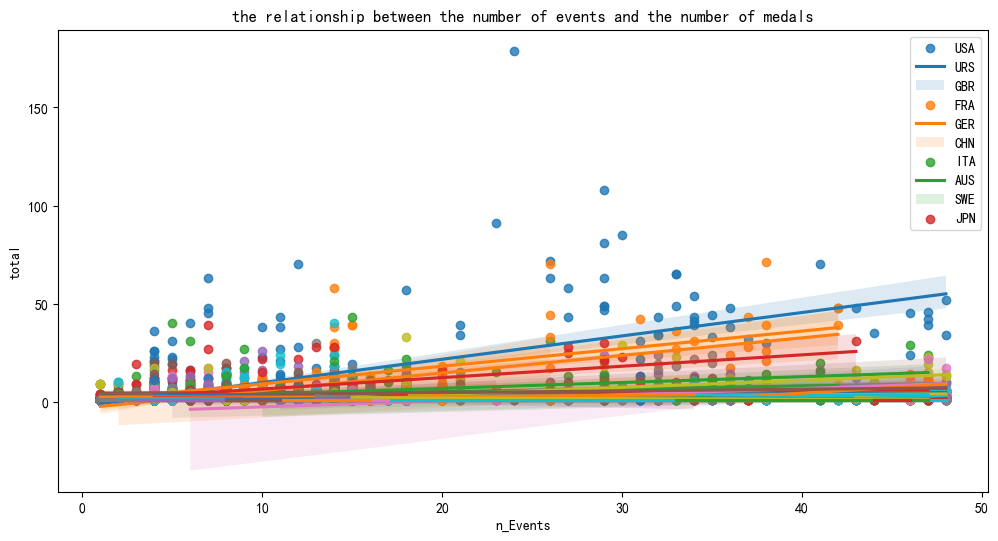

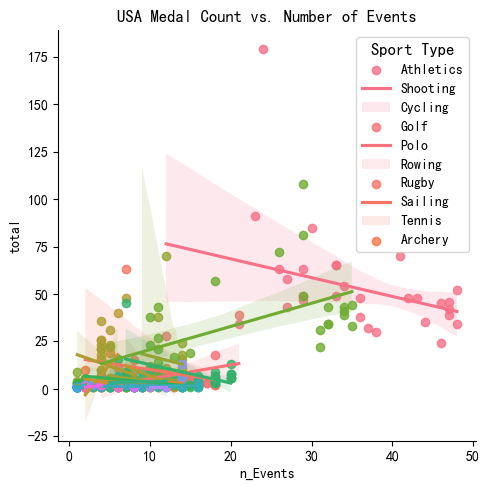

In [4]:
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.formula.api import glm
from statsmodels.genmod.families import NegativeBinomial

## 使得图片能够显示中文
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

df2 = pd.read_csv('../data/Final_csv/result3.csv')
# df2 = df2.drop(columns='Total')
# 计算每届各运动大类的子项目数量
events_per_sport = df2.groupby(['Year', 'sport'])['event'].nunique().reset_index(name='n_Events')
# 按国家-运动-年份统计奖牌数
country_sport_medals = df2.groupby(['Year', 'country', 'sport']).agg({
    'gold': 'sum',
    'silver': 'sum',
    'bronze': 'sum'
}).reset_index()
country_sport_medals['total'] = country_sport_medals[['gold', 'silver', 'bronze']].sum(axis=1)


merged = pd.merge(country_sport_medals, events_per_sport, on=['Year', 'sport'])



poisson_model = sm.GLM(merged['total'], 
                      sm.add_constant(merged[['n_Events']]), 
                      family=sm.families.Poisson()).fit()

nb_model = sm.GLM(merged['total'], 
                 sm.add_constant(merged[['n_Events']]), 
                 family=sm.families.NegativeBinomial()).fit()

# 比较AIC/BIC
print("泊松模型AIC:", poisson_model.aic)
print("负二项模型AIC:", nb_model.aic)

# 过离散检验（若α>1则拒绝泊松假设）
alpha = nb_model.params[-1]  # 负二项离散参数
print(f"过离散参数α={alpha:.3f} (若显著>0则需用负二项)")

# 使用面板回归模型
model = glm(
    formula='total ~ n_Events + C(country) + C(Year)', 
    data=merged,
    family=NegativeBinomial(link=sm.genmod.families.links.Log())  # 使用对数连接函数
).fit()

print(model.summary())



# 可视化相关性，选择奖牌数量最多的前3个国家

most_countries = merged.groupby('country')['total'].sum().sort_values(ascending=False).index
print(most_countries)

# 把这五个国家的数据画在一个大图上
plt.figure(figsize=(12, 6))
for country in most_countries:
    country_data = merged[merged['country'] == country]
    sns.regplot(x='n_Events', y='total', data=country_data, label=country)
    
#legend只写前5个国家
plt.legend(most_countries[:10])
plt.title('the relationship between the number of events and the number of medals')





sns.lmplot(x='n_Events', y='total', hue='sport', data=merged.query("country=='USA'"),legend=False)
leg = plt.legend(merged.query("country=='USA'")['sport'].unique()[:10])
leg.set_title('Sport Type', prop={'size': 12, 'weight': 'bold'})
plt.title('USA Medal Count vs. Number of Events')

plt.tight_layout()
plt.show()







In [5]:
## 计算各国年度总奖牌数
country_year_total = country_sport_medals.groupby(['Year', 'country'])['total'].sum().reset_index()

#合并计算各个运动占比
hhi_data = pd.merge(
    country_sport_medals,
    country_year_total,
    on=['Year', 'country'],
    suffixes=('_sport', '_total')
)
hhi_data['share'] = hhi_data['total_sport'] / hhi_data['total_total']

# 计算动态HHi
def calculate_hhi(group):
    return (group['share']**2).sum()

hhi = hhi_data.groupby(['Year', 'country']).apply(calculate_hhi).reset_index(name='hhi')


MIN_YEARS = 3  # 至少出现X届奥运会才视为核心项目
THRESHOLD = 0.15  # 平均占比超过15%视为重要

# 按运动项目聚合时间序列数据
def analyze_core_sports(country):
    country_data = hhi_data.query(f"country == '{country}'")
    
    # 计算各运动项目的持续表现
    sport_stats = country_data.groupby('sport').agg(
        avg_share=('share', 'mean'),  # 平均奖牌占比
        max_share=('share', 'max'),    # 历史最高占比
        n_years=('Year', 'nunique'),   # 出现届数
        last_decade_avg=('Year', lambda x: country_data[
            (country_data['sport'].isin(x)) & 
            (country_data['Year'] >= max(x)-12)  # 最近三届（假设每4年一届）
        ]['share'].mean())
    ).reset_index()
    
    # 筛选核心项目标准
    core_sports = sport_stats[
        (sport_stats['n_years'] >= MIN_YEARS) & 
        (sport_stats['avg_share'] >= THRESHOLD)
    ].sort_values('avg_share', ascending=False)
    
    return core_sports



# 批量分析所有国家核心项目
all_countries = hhi_data['country'].unique()
core_sports_global = pd.concat(
    [analyze_core_sports(c).assign(country=c) for c in all_countries]
)

# 生成全球核心项目榜单
top_global = core_sports_global.groupby('sport').agg(
    n_countries=('country', 'nunique'),
    avg_share=('avg_share', 'mean')
).sort_values('n_countries', ascending=False).head(10)

print("全球最广泛核心项目:")
print(top_global)




## 现在我想分析出美国的核心项目
core_sports_usa = analyze_core_sports('USA')
print("美国核心项目:")
print(core_sports_usa)


C:\Users\16972\AppData\Local\Temp\ipykernel_21728\1670688239.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  hhi = hhi_data.groupby(['Year', 'country']).apply(calculate_hhi).reset_index(name='hhi')


全球最广泛核心项目:
               n_countries  avg_share
sport                                
Athletics               56   0.501309
Boxing                  36   0.441839
Wrestling               29   0.361769
Shooting                20   0.372560
Rowing                  19   0.326703
Weightlifting           19   0.360189
Judo                    19   0.354463
Swimming                18   0.323742
Sailing                 14   0.336333
Cycling                 13   0.244949
美国核心项目:
        sport  avg_share  max_share  n_years  last_decade_avg
5   Athletics   0.419254   0.971429       30              NaN
45   Swimming   0.234013   0.577540       28              NaN


In [6]:
# 确保使用统一数据集并进行数据预处理
df_host = df2.copy()
df_host['host'] = df_host['host'].astype(int)
# 添加一个小的常数以避免零值问题
# 改进1：精确识别新增小项（考虑项目全称唯一性）
def get_new_events(host_year):
    """识别当届首次出现的具体小项（精确到运动大类+小项）"""
    prev_events = df_host[df_host['Year'] < host_year]['event'].unique()
    current_events = df_host[df_host['Year'] == host_year]['event'].unique()
    return list(set(current_events) - set(prev_events))

# 改进2：完善战略项目定义
def mark_strategic_events(host, host_year):
    """
    战略新增项目定义（同时满足）：
    1. 当届新增的具体小项（event）
    2. 东道主在该小项的历史奖牌数 == 0（严格排除已有优势项目）
    3. 东道主当届在该小项获得奖牌数 >= 1（降低阈值提高敏感性）
    """
    strategic_events = []
    for event in get_new_events(host_year):
        # 历史奖牌检查（严格条件）
        hist_medals = df_host[(df_host['country'] == host) & 
                             (df_host['event'] == event) & 
                             (df_host['Year'] < host_year)]['Total'].sum()
        
        # 当届奖牌检查
        current_medals = df_host[(df_host['country'] == host) & 
                                (df_host['event'] == event) & 
                                (df_host['Year'] == host_year)]['Total'].sum()
        
        if hist_medals == 0 and current_medals >= 1:
            strategic_events.append(event)
    return strategic_events
hosts = df_host.query("host == 1")[['country', 'Year']].drop_duplicates()
# 改进3：构建更严谨的面板数据

# Improve data handling before modeling
# 1. Add epsilon to handle zeros and adjust negative values
analysis_data = []
for _, row in hosts.iterrows():
    host, host_year = row['country'], row['Year']
    strategic_events = mark_strategic_events(host, host_year)
    
    # Calculate strategic medals (处理组)
    strategic_medals = df_host[(df_host['country'] == host) & 
                             (df_host['Year'] == host_year) & 
                             (df_host['event'].isin(strategic_events))]['Total'].sum()
    
    # Calculate non-strategic baseline using previous years
    base_period = [host_year-4, host_year-8]
    non_strategic_base = df_host[(df_host['country'] == host) & 
                                (df_host['Year'].isin(base_period)) & 
                                (~df_host['event'].isin(strategic_events))]['Total'].mean()
    
    non_strategic_current = df_host[(df_host['country'] == host) & 
                                   (df_host['Year'] == host_year) & 
                                   (~df_host['event'].isin(strategic_events))]['Total'].sum()
    
    # Calculate medal changes and ensure they are non-negative
    strategic_change = max(0.1, strategic_medals)  # Add small constant to avoid zeros
    non_strategic_change = max(0.1, non_strategic_current - non_strategic_base)
    
    analysis_data.extend([
        {
            'host': host, 
            'Year': host_year, 
            'type': 'strategic', 
            'medal_change': strategic_change,
            'total_medals': strategic_medals + non_strategic_current
        },
        {
            'host': host, 
            'Year': host_year, 
            'type': 'non_strategic', 
            'medal_change': non_strategic_change,
            'total_medals': strategic_medals + non_strategic_current
        }
    ])

# Convert to DataFrame
did_df = pd.DataFrame(analysis_data)

# Try alternative model specification using Poisson regression
model = glm(
    formula='medal_change ~ type * C(host) + Year + total_medals',  # Add total medals control
    data=did_df,
    family=sm.families.Poisson()  # Use Poisson instead of Negative Binomial
).fit()

# Print model results
print(model.summary())

# Visualize results
# plt.figure(figsize=(10,6))
# sns.boxplot(x='type', y='medal_change', data=did_df, showfliers=False)
# plt.axhline(0, color='red', linestyle='--')
# plt.title('Strategic vs Non-Strategic Medal Changes')
# plt.xlabel('Event Type')
# plt.ylabel('Medal Change')
# plt.show()



# 获取所有东道主国家及其主办年份

# 存储每个国家的战略项目及其奖牌贡献
strategic_events_impact = []

for _, row in hosts.iterrows():
    host, host_year = row['country'], row['Year']
    strategic_events = mark_strategic_events(host, host_year)
    
    # 统计当届战略项目的奖牌数
    medals = df_host[(df_host['country'] == host) & 
                    (df_host['Year'] == host_year) & 
                    (df_host['event'].isin(strategic_events))]['Total'].sum()
    
    # 记录结果
    strategic_events_impact.append({
        'country': host,
        'Year': host_year,
        'strategic_events': strategic_events,
        'medals_from_strategic': medals,
        'rate': medals / df_host[(df_host['country'] == host) & (df_host['Year'] == host_year)]['Total'].sum()
    })

# 转换为DataFrame
strategic_impact_df = pd.DataFrame(strategic_events_impact)
print(strategic_impact_df)

                 Generalized Linear Model Regression Results                  
Dep. Variable:           medal_change   No. Observations:                   66
Model:                            GLM   Df Residuals:                       22
Model Family:                 Poisson   Df Model:                           43
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -683.44
Date:                Mon, 27 Jan 2025   Deviance:                       1067.9
Time:                        21:13:29   Pearson chi2:                     905.
No. Iterations:                    10   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

C:\Users\16972\AppData\Local\Temp\ipykernel_21728\1233559500.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Year', y='rate', data=strategic_impact_df, palette='viridis') #  可以尝试更柔和的绿色，例如 "#58D68D"
C:\Users\16972\AppData\Local\Temp\ipykernel_21728\1233559500.py:32: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout() #  自动调整子图参数，避免标签被裁剪


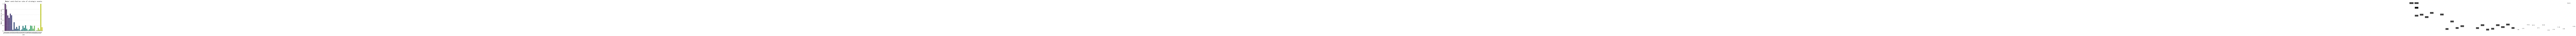

In [7]:
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 使用更柔和的绿色，并保持你之前的颜色也是可以的
sns.barplot(x='Year', y='rate', data=strategic_impact_df, palette='viridis') #  可以尝试更柔和的绿色，例如 "#58D68D"

plt.title('Medal contribution rate of strategic events', fontsize=16)
plt.xlabel('year', fontsize=12) #  X 轴标签使用中文更统一
plt.ylabel('Medal contribution rate', fontsize=12) # Y 轴标签更清晰
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
sns.despine()

# 3. 添加标签，调整位置和样式
for index, row in strategic_impact_df.iterrows():
    rate_percent = "{:.1%}".format(row['rate'])
    plt.text(row['Year'],
             row['rate'] + 0.01,  # 稍微减小向上偏移
             rate_percent,
             ha='center',
             va='bottom',
             fontsize=10,
             color='black',
                         bbox=dict(facecolor='black',
                      edgecolor='none',
                      alpha=0.7)) #  标签颜色改为黑色，更清晰

#  移除背景框，如果需要可以添加更柔和的背景框



plt.tight_layout() #  自动调整子图参数，避免标签被裁剪
plt.show()


             Feature        Score
0   Number_of_people  2387.419031
86       Lag_Total_1  2363.405373
77        Lag_Gold_1  2178.174720
87       Lag_Total_2  2050.341856
78        Lag_Gold_2  2035.941526
80      Lag_Silver_1  1974.885731
83      Lag_Bronze_1  1834.244792
81      Lag_Silver_2  1665.244568
84      Lag_Bronze_2  1586.715003
88       Lag_Total_3  1537.512195
79        Lag_Gold_3  1439.196192
82      Lag_Silver_3  1345.303426
85      Lag_Bronze_3  1274.712528


C:\Users\16972\AppData\Local\Temp\ipykernel_21728\3342503142.py:75: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=selected_features.head(20), x='Feature', y='Score', palette='viridis')


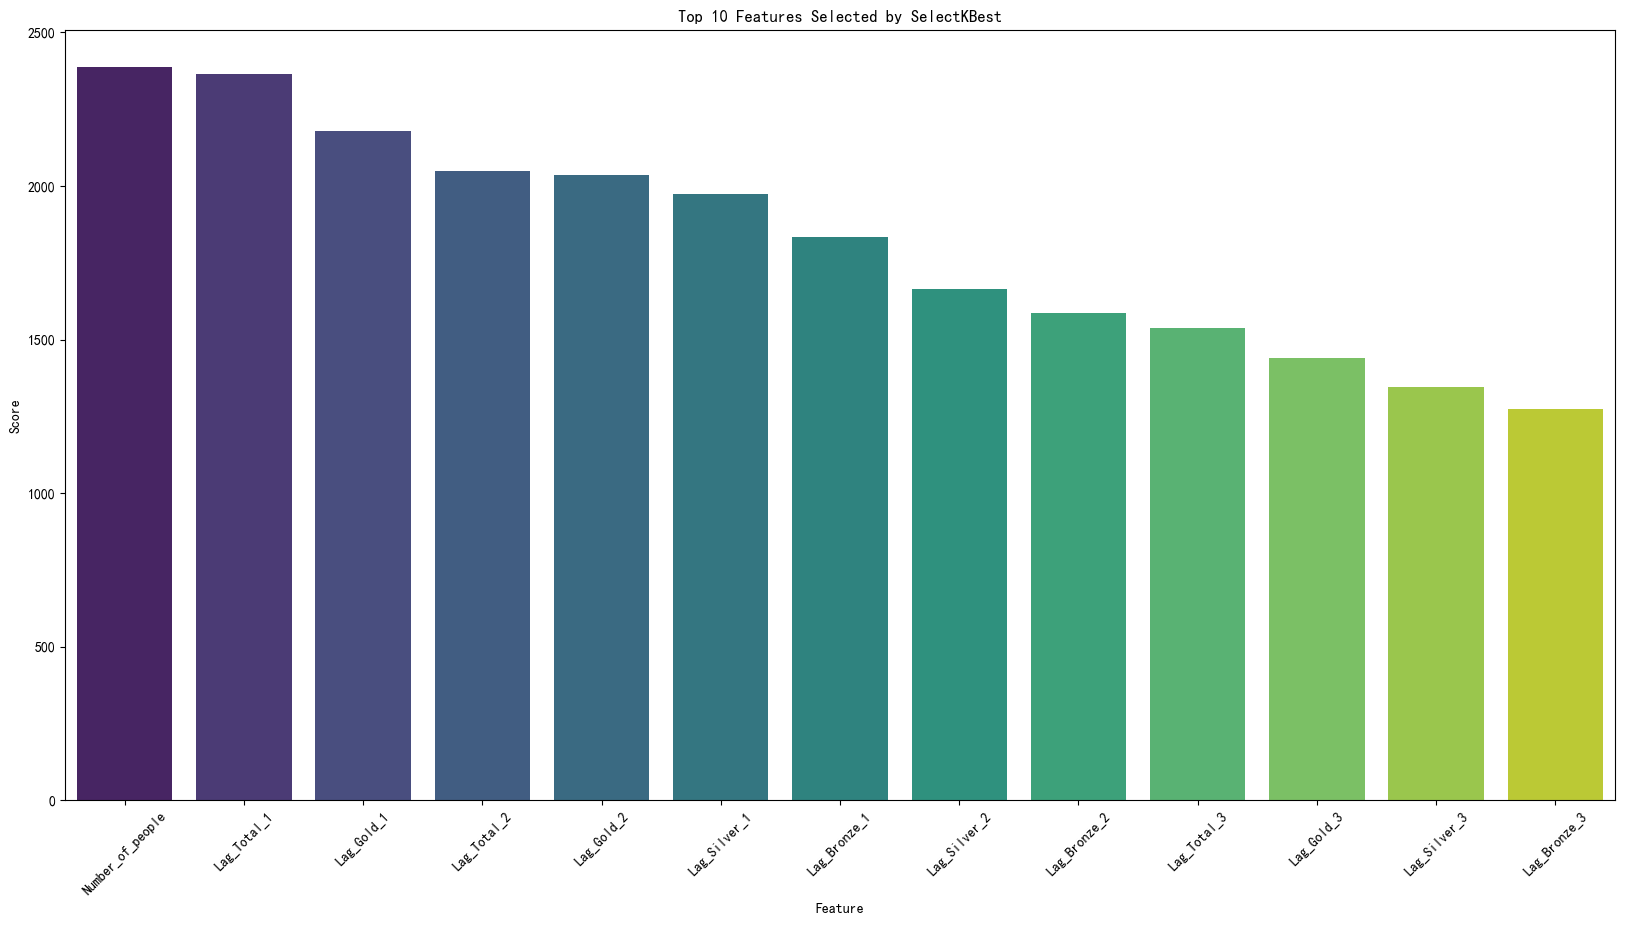

In [8]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
from xgboost import XGBRegressor




## 进行特征筛选
# 设置可视化风格
sns.set_palette("husl")



def preprocess_data(df):
    # 生成金牌，银牌，铜牌和总奖牌数的滞后特征
    first_year = df['Year'].min()
    for medal in ['Gold', 'Silver', 'Bronze', 'Total']:
        for i in range(1, 4):
            df[f'Lag_{medal}_{i}'] = df.groupby('NOC')[medal].shift(i)
            df.loc[df['Year'] == first_year, f'Lag_{medal}_{i}'] = 0
    
        
    # 创建主办国交互特征
    events_col = [col for col in df.columns if 'Event' in col]
    for event in events_col:
        df[f'{event}_Host'] = df['Host'] * df[event]
        
    
    # 检查如果滞后特征中有缺失值，我们需要填充缺失值
    for medal in ['Gold', 'Silver', 'Bronze', 'Total']:
        for i in range(1, 4):
            df[f'Lag_{medal}_{i}'] = df[f'Lag_{medal}_{i}'].fillna(0)
        
    return df


# 特征筛选
def feature_selection_KBEST(df,k=10,target='Total'):
    # 选择特征
    feature = [col for col in df.columns if col not in ['NOC', 'Year', 'Host', 'Total','Gold', 'Silver', 'Bronze']]
    sekector = SelectKBest(f_regression, k=k)
    X_selected = sekector.fit_transform(df[feature], df[target])
    selected_features = df[feature].columns[sekector.get_support()]
    #返回选择的特征的统计值,只选择前10个
    statisc_value = pd.DataFrame({
        'Feature': feature,
        'Score': sekector.scores_
    }).sort_values('Score', ascending=False)
    
    return statisc_value
def feature_selection_xgboost(df,target='Total'):
    feature = [col for col in df.columns if col not in ['NOC', 'Year', 'Host', 'Total','Gold', 'Silver', 'Bronze']]
    model = XGBRegressor(objective='reg:squarederror', n_estimators=100)
    model.fit(df[feature], df[target])
    
    
    importance = pd.DataFrame({
        'Feature': feature,
        'Importance': model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    return importance


# 数据预处理
df = preprocess_data(df)
# 选择特征
selected_features = feature_selection_KBEST(df, k=10).head(13)
print(selected_features)

# 对这个selected_features进行可视化
plt.figure(figsize=(20, 10))
sns.barplot(data=selected_features.head(20), x='Feature', y='Score', palette='viridis')
plt.xticks(rotation=45)
plt.title('Top 10 Features Selected by SelectKBest')
plt.show()






In [11]:

from pmdarima import auto_arima
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.statespace.sarimax import SARIMAXResultsWrapper
from typing import Tuple, Dict
import pmdarima as pm

pd.options.mode.chained_assignment = None  # 关闭警告

##给df添加一个新的列，用来表示当届奥运会总项目数,除了NOC,Gold,Silver，Bronze，Total，Year，Host
sport = df.columns[8:-1]
df['Total_event'] = df[sport].sum(axis=1)
def arimax_forecast(country_df, exog_cols, target):
    """移除is_host后的ARIMAX预测"""
    # 数据预处理
    country_df = country_df.sort_values('Year').reset_index(drop=True)
    if country_df.empty:
        print("Warning: Empty DataFrame for country")
        return None, None, None
    noc = country_df['NOC'].iloc[0]
    
    # # 检查时间连续性（奥运会每4年一届）
    # year_diff = country_df['Year'].diff().dropna()
    # if not (year_diff == 4).all():
    #     print(f"Skipping {noc}: Irregular time intervals (e.g., missing Olympics)")
    #     return None, None, None
    
    # 划分训练集（历史数据截止到2024）
    train_data = country_df[country_df['Year'] <= 2024]
    if len(train_data) < 2:  # 至少需要2届数据
        return None, None, None
    
    # 训练ARIMAX模型（注意：exog_cols不应包含is_host）
    try:
        model = auto_arima(
            train_data[target],
            exogenous=train_data[exog_cols],  # 确保此处只包含athletes等保留变量
            seasonal=False,
            error_action='ignore',
            trace=0
        )
    except Exception as e:
        print(f"ARIMA fitting failed for {noc}: {e}")
        return None, None, None
    
    # 构建未来外生变量（仅保留变量如athletes）,我计划使用前3届的平均值
    future_exog_values = train_data[exog_cols].tail(3).mean().values
    future_exog = pd.DataFrame([future_exog_values], columns=exog_cols)
    
    
    
    # 执行预测
    try:
        forecast, conf_int = model.predict(
            n_periods=1,
            exogenous=future_exog,
            return_conf_int=True,
            alpha=0.05  # 95%置信区间
        )

        return model, forecast.iloc[0], conf_int
    except Exception as e:
        print(f"Prediction failed for {noc}: {e}")
        return None, None, None


def xgb_residual_model(train_X: pd.DataFrame, train_Y: pd.Series, test_X: pd.DataFrame, n_splits: int = 3) -> Tuple[float, float]:
    """修复数据泄漏和特征问题的残差预测"""
    if train_X.empty or len(train_Y) == 0:
        return np.nan, np.nan
    
    # 确保训练数据和标签长度匹配
    if len(train_X) != len(train_Y):
        min_len = min(len(train_X), len(train_Y))
        train_X = train_X.iloc[:min_len]
        train_Y = train_Y.iloc[:min_len]
    
    # 动态调整交叉验证折数
    n_splits = min(n_splits, len(train_X) - 4)  # 确保折数小于样本数
    # print(f"the number of splits is {n_splits}")
    # print(f"the length of train_X is {len(train_X)}")

    if n_splits <= 2:  # 如果样本太少，无法进行交叉验证
        # print(f"样本数量不足进行{n_splits}折交叉验证，将直接使用全部数据训练")
        # 使用所有数据训练一个模型
        model = xgb.XGBRegressor(
            objective='reg:squarederror',
            n_estimators=100,
            learning_rate=0.1,
            max_depth=3
        )
        try:
            model.fit(train_X, train_Y)
            pred = model.predict(test_X)[0] if len(test_X) > 0 else np.nan
            if pred is None:
                xgb_cv_residuals = np.nan
            else:
                xgb_cv_residuals = train_Y - pred

            
            return pred, pred, xgb_cv_residuals
        except Exception as e:
            print(f"Model training failed: {e}")
            return np.array([np.nan]), np.array([np.nan]), np.array([np.nan])
    """修复数据泄漏和特征问题的残差预测"""
    if train_X.empty or len(train_Y) == 0:
        return np.array([np.nan]), np.array([np.nan]), np.array([np.nan])
    
    # 滞后特征配置
    lag_features = [1, 2]
    max_lag = max(lag_features)
    
    # 检查训练数据是否足够生成滞后
    if len(train_Y) < max_lag:
        print(f"数据不足，需要至少{max_lag}个观测值生成滞后特征")
        return np.array([np.nan]), np.array([np.nan]), np.array([np.nan])
    
    # 训练集滞后特征
    for lag in lag_features:
        train_X[f'lag{lag}'] = train_Y.shift(lag)
    
    # 测试集滞后特征（严格使用历史值）
    test_lags = {f'lag{lag}': train_Y.iloc[-lag] for lag in lag_features}
    test_X = test_X.assign(**test_lags)
    
    # 删除包含NaN的行（保留至少max_lag之后的数据）
    train_X_clean = train_X.iloc[max_lag:].copy()
    train_Y_clean = train_Y.iloc[max_lag:]
    
    if train_X_clean.empty:
        return np.array([np.nan]), np.array([np.nan]), np.array([np.nan])
    
    # 重置索引确保对齐
    train_X_clean = train_X_clean.reset_index(drop=True)
    train_Y_clean = train_Y_clean.reset_index(drop=True)

    # 添加滚动特征（窗口大小为）
    train_X_clean['rolling_mean_2'] = train_Y_clean.rolling(window=2,closed='left',min_periods=1).mean()
    # 删除滚动特征带来的新NaN行
    valid_rows = train_X_clean.dropna().index
    train_X_clean = train_X_clean.loc[valid_rows]
    train_Y_clean = train_Y_clean.loc[valid_rows]

    # 测试集滚动特征（使用训练集最后两个有效值）
    test_X['rolling_mean_2'] = train_Y_clean.iloc[-2:].mean()
    
    # 时间序列交叉验证
    tscv = TimeSeriesSplit(n_splits=n_splits)
    test_preds = []
    cv_residuals = np.zeros(len(train_Y_clean))  # 初始化存储容器

    # print(f"使用{n_splits}折交叉验证训练模型")
    # print(f"训练集样本数: {len(train_X_clean)}")
    for train_idx, val_idx in tscv.split(train_X_clean):
        # 分割数据
        fold_train_X = train_X_clean.iloc[train_idx]
        fold_train_Y = train_Y_clean.iloc[train_idx]
        fold_val_X = train_X_clean.iloc[val_idx]
        fold_val_Y = train_Y_clean.iloc[val_idx]
        
        # 标准化（仅在fold训练集上fit）
        fold_scaler = StandardScaler()
        X_train_scaled = fold_scaler.fit_transform(fold_train_X)
        X_val_scaled = fold_scaler.transform(fold_val_X)
        
        # 训练模型
        model = xgb.XGBRegressor(
            objective='reg:squarederror',
            n_estimators=300,
            learning_rate=0.05,
            max_depth=3,
            subsample=0.8,
            random_state=42
        )
        model.fit(X_train_scaled, fold_train_Y)
        
        # 预测测试集（需标准化）
        test_X_scaled = fold_scaler.transform(test_X)
        val_pred = model.predict(test_X_scaled)
        test_preds.append(val_pred)
        cv_residuals[val_idx] = val_pred  # 保存预测值

    
    # 最终模型训练（独立scaler）
    final_scaler = StandardScaler()
    X_full_scaled = final_scaler.fit_transform(train_X_clean)
    test_X_scaled = final_scaler.transform(test_X)
    
    final_model = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=300,
        learning_rate=0.05,
        max_depth=3,
        subsample=0.8,
        random_state=42
    ).fit(X_full_scaled, train_Y_clean)
    
    final_pred = final_model.predict(test_X_scaled)
    # Ensure we return scalar values
    mean_pred = float(np.mean(test_preds)) if test_preds else np.nan
    xgb_cv_residuals = train_Y_clean - cv_residuals

    final_pred_value = float(final_pred[0]) if len(final_pred) > 0 else np.nan
    return mean_pred, final_pred_value, xgb_cv_residuals


def get_future_exog(country_df: pd.DataFrame, exog_cols: list, target_year: int) -> pd.DataFrame:
    """
    根据历史数据生成未来外生变量预测值
    
    参数:
    - country_df: 国家历史数据
    - exog_cols: 外生变量列名列表
    - target_year: 目标预测年份
    
    返回:
    - 包含预测外生变量的DataFrame
    """
    # 使用最近3届的平均值作为预测值
    recent_data = country_df.sort_values('Year', ascending=False).head(3)
    future_values = recent_data[exog_cols].mean()
    
    # 创建新的DataFrame
    future_exog = pd.DataFrame([future_values], columns=exog_cols)
    return future_exog

def calculate_uncertainty(
    arima_mean: float,
    arima_conf,
    xgb_pred: float,
    xgb_residuals: pd.Series,  # 明确要求传入XGBoost的交叉验证残差
    arima_residuals: pd.Series,  # ARIMA的残差（用于协方差计算）
    use_bootstrap: bool = True  # 是否启用更精确的Bootstrap方法
) -> Dict[str, float]:
    """综合不确定性计算，包含协方差和分布修正"""
    if np.isnan(arima_mean) or np.isnan(xgb_pred):
        return {'lower': np.nan, 'upper': np.nan}
    
    # 计算标准差（防御性默认值）
    arima_std = (
        (arima_conf[0][1] - arima_conf[0][0]) / (2 * 1.96) 
        if arima_conf is not None 
        else np.std(arima_residuals.values, ddof=1)  # 若无置信区间，用历史残差标准差
    )
    xgb_std = (
        np.std(xgb_residuals, ddof=1) 
        if not xgb_residuals.empty and len(xgb_residuals) > 1 
        else max(0.1 * abs(xgb_pred), 3)  # 防止为0
    )

    # 确保残差序列长度匹配
    min_length = min(len(arima_residuals), len(xgb_residuals))
    if min_length > 1:
        # 转换为NumPy数组并截断
        arima_arr = arima_residuals.values[:min_length]
        xgb_arr = xgb_residuals.values[:min_length]
        # 检查并处理可能的NaN
        if np.isnan(arima_arr).any() or np.isnan(xgb_arr).any():
            cov_matrix = np.array([[arima_std**2, 0], [0, xgb_std**2]])
        else:
            cov_matrix = np.cov(arima_arr, xgb_arr, rowvar=False)
    else:
        cov_matrix = np.array([[arima_std**2, 0], [0, xgb_std**2]])
    
    if use_bootstrap:
        # 考虑协方差后的Bootstrap采样
        n_samples = 1000
        arima_samples = np.random.normal(arima_mean, arima_std, n_samples)
        xgb_samples = np.random.multivariate_normal(
            mean=[xgb_pred, 0],  # 假设xgb残差均值为0
            cov=[[xgb_std**2, cov_matrix[0,1]], [cov_matrix[1,0], cov_matrix[1,1]]],
            size=n_samples
        )[:, 0]
        combined = arima_samples + xgb_samples
        lower = np.percentile(combined, 5)
        upper = np.percentile(combined, 95)
    else:
        # 简单正态假设（带对数修正）
        total_mean = arima_mean + xgb_pred
        total_std = np.sqrt(arima_std**2 + xgb_std**2 + 2 * cov_matrix[0,1])
        lower = max(0, total_mean - 1.96 * total_std)
        upper = total_mean + 1.96 * total_std
    
    # 确保预测值非负
    lower = max(0, lower)
    
    return {'lower': lower, 'upper': upper}
           


def main(df):
    targets = ['Gold', 'Silver', 'Bronze', 'Total']
    exog_cols = ['Number_of_people','Total_event']
    final_predictions = []
    all_countries = df['NOC'].unique()
    # all_countries = ['United_States','China']
    for noc in all_countries:
        country_df = df[df['NOC'] == noc].sort_values('Year').reset_index(drop=True)
        if len(country_df) == 0:
            continue

        # 获取2024年实际值（如果存在）
        if 2024 in country_df['Year'].values:
            actual_2024_df = country_df.loc[country_df['Year'] == 2024, targets]
            if not actual_2024_df.empty:
                actual_2024 = actual_2024_df.iloc[0]
            else:
                actual_2024 = pd.Series([np.nan]*4, index=targets)
        else:
            actual_2024 = pd.Series([np.nan]*4, index=targets)

        # 预测2024作为基准（使用截止到2020的数据）
        baseline_2024_pred = {}
        for target in targets:
            baseline_model, pred, _ = arimax_forecast(
                country_df[country_df['Year'] <= 2020], 
                exog_cols, 
                target,
            )
            baseline_2024_pred[target] = pred if pred is not None else np.nan

        # 预测2028
        for target in targets:
            print(f"Predicting {noc} - {target}...")
            # ARIMAX预测
            model, arima_pred, arima_conf = arimax_forecast(
                country_df, 
                exog_cols, 
                target,
            )
            
            
        # if model is not None:
        #     if noc == 'United_States':
        #         model.plot_diagnostics(figsize=(12, 8))
        #         plt.suptitle(f"Residual Diagnostics ({noc})", y=1.02)
        #         plt.tight_layout()
        #         plt.show()
            
            
            # Get ARIMA residuals from model if available
            if arima_pred is None:
                final_predictions.append({
                    'NOC': noc, 'Target': target, 
                    '2028_pred': np.nan, '2028_lower': np.nan, '2028_upper': np.nan,
                    '2024_actual': actual_2024.get(target, np.nan),
                    '2024_pred': baseline_2024_pred.get(target, np.nan)
                })
                continue

            # 准备XGBoost特征（含滞后项）
            train_data = country_df[country_df['Year'] <= 2024].copy()

            train_X = train_data[exog_cols]

            # XGB残差预测
            future_exog = get_future_exog(country_df, exog_cols, 2028)
            xgb_test = future_exog.copy()
            residuals = train_data[target] - model.predict_in_sample(
                exogenous=train_data[exog_cols]
            )
            xgb_cv_pred, xgb_full_pred, xgb_cv_residuals = xgb_residual_model(
                train_X, 
                residuals.astype(float), 
                xgb_test
            )

            # 处理预测值
            if isinstance(xgb_full_pred, (np.ndarray, list)):
                xgb_pred_value = xgb_full_pred[0] if len(xgb_full_pred) > 0 else 0
            else:
                xgb_pred_value = xgb_full_pred if not np.isnan(xgb_full_pred) else 0
            # 综合预测与不确定性
            combined_pred = arima_pred + xgb_pred_value
            uncertainty = calculate_uncertainty(
                arima_pred, arima_conf, xgb_full_pred,
                xgb_residuals=xgb_cv_residuals,  # 应替换为交叉验证残差
                arima_residuals=residuals
            )

            final_predictions.append({
                'NOC': noc, 'Target': target, 
                '2028_pred': combined_pred, 
                '2028_lower': uncertainty['lower'], 
                '2028_upper': uncertainty['upper'],
                '2024_actual': actual_2024.get(target, np.nan),
                '2024_pred': baseline_2024_pred.get(target, np.nan)
            })

    # 后续处理与校验
    result_df = pd.DataFrame(final_predictions)
    result_df['improvement'] = result_df['2028_pred'] - result_df['2024_actual']

    # 总奖牌数一致性检查
    def validate_total(row):
        if row['Target'] != 'Total':
            return row
        subset = result_df[(result_df['NOC'] == row['NOC']) & (result_df['Target'].isin(['Gold','Silver','Bronze']))]
        sum_pred = subset['2028_pred'].sum()
        if abs(row['2028_pred'] - sum_pred) > 10:
            row['2028_pred'] = sum_pred  # 强制对齐
            print(f"修正 {row['NOC']} 的总奖牌数为分项之和: {sum_pred}")
        return row

    result_df = result_df.apply(validate_total, axis=1)\
    
        
    # 重新整理数据框架
    pivot_df = result_df.pivot(index='NOC', columns='Target', values=['2028_pred', '2028_lower', '2028_upper','improvement']).reset_index()
    pivot_df.columns = [f'{col[1]}_{col[0]}' if col[1] != '' else col[0] for col in pivot_df.columns]
    pivot_df = pivot_df.rename(columns={
        'NOC': 'Country',
        'Gold_2028_pred': 'Gold',
        'Silver_2028_pred': 'Silver',
        'Bronze_2028_pred': 'Bronze',
        'Total_2028_pred': 'Total',
        'Gold_2028_lower': 'Gold_lower',
        'Gold_2028_upper': 'Gold_upper',
        'Silver_2028_lower': 'Silver_lower',
        'Silver_2028_upper': 'Silver_upper',
        'Bronze_2028_lower': 'Bronze_lower',
        'Bronze_2028_upper': 'Bronze_upper',
        'Total_2028_lower': 'Total_lower',
        'Total_2028_upper': 'Total_upper',
        'Total_improvement': 'Total_improvement',
        'Gold_improvement': 'Gold_improvement'
    })
    
    # 计算improvement (如果需要)
    pivot_df['Gold_improvement'] = pivot_df['Gold_improvement']
    pivot_df['Total_improvement'] = pivot_df['Total_improvement']
    
    # 选择最终需要的列
    result_df = pivot_df[[
        'Country', 'Gold', 'Silver', 'Bronze', 'Total',
        'Gold_improvement', 'Total_improvement',
        'Gold_lower', 'Gold_upper', 'Silver_lower', 'Silver_upper',
        'Bronze_lower', 'Bronze_upper', 'Total_lower', 'Total_upper'
    ]]
    
    # result_df = result_df.sort_values('Total', ascending=False)
    result_df = result_df.reset_index(drop=True)
    
    
    # 结果展示
    print("\n2028年奖牌预测TOP10:")
    #对总奖牌Total进行排序
    result_df = result_df.sort_values('Total', ascending=False)
    result_df.to_csv('2028_olympic_forecast.csv', index=False)
    
    print(result_df.head(10))

main(df)
    
    

Predicting United_States - Gold...
Predicting United_States - Silver...
Predicting United_States - Bronze...
Predicting United_States - Total...
Predicting Greece - Gold...
Predicting Greece - Silver...
Predicting Greece - Bronze...
Predicting Greece - Total...
Predicting Germany - Gold...
Predicting Germany - Silver...
Predicting Germany - Bronze...
Predicting Germany - Total...
Predicting France - Gold...
Predicting France - Silver...
Predicting France - Bronze...
Predicting France - Total...
Predicting Great_Britain - Gold...
Predicting Great_Britain - Silver...
Predicting Great_Britain - Bronze...
Predicting Great_Britain - Total...
Predicting Hungary - Gold...
Predicting Hungary - Silver...
Predicting Hungary - Bronze...
Predicting Hungary - Total...
Predicting Austria - Gold...
Predicting Austria - Silver...
Predicting Austria - Bronze...
Predicting Austria - Total...
Predicting Australia - Gold...
Predicting Australia - Silver...
Predicting Australia - Bronze...
Predicting Austr

e:\applist\miniconda\envs\sklearn\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
e:\applist\miniconda\envs\sklearn\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


Predicting Luxembourg - Gold...
Predicting Luxembourg - Silver...
Predicting Luxembourg - Bronze...
Predicting Luxembourg - Total...


e:\applist\miniconda\envs\sklearn\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
e:\applist\miniconda\envs\sklearn\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


Predicting Norway - Gold...
Predicting Norway - Silver...
Predicting Norway - Bronze...
Predicting Norway - Total...
Predicting Netherlands - Gold...
Predicting Netherlands - Silver...
Predicting Netherlands - Bronze...
Predicting Netherlands - Total...
Predicting India - Gold...
Predicting India - Silver...
Predicting India - Bronze...
Predicting India - Total...


e:\applist\miniconda\envs\sklearn\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
e:\applist\miniconda\envs\sklearn\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
e:\applist\miniconda\envs\sklearn\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
e:\applist\miniconda\envs\sklearn\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


ARIMA fitting failed for Bohemia: too many indices for array: array is 0-dimensional, but 1 were indexed
ARIMA fitting failed for Bohemia: too many indices for array: array is 0-dimensional, but 1 were indexed
Predicting Bohemia - Gold...
Predicting Bohemia - Silver...
ARIMA fitting failed for Bohemia: too many indices for array: array is 0-dimensional, but 1 were indexed
Predicting Bohemia - Bronze...
ARIMA fitting failed for Bohemia: too many indices for array: array is 0-dimensional, but 1 were indexed
Predicting Bohemia - Total...
Predicting Sweden - Gold...
Predicting Sweden - Silver...
Predicting Sweden - Bronze...
Predicting Sweden - Total...
ARIMA fitting failed for Australasia: too many indices for array: array is 0-dimensional, but 1 were indexed
ARIMA fitting failed for Australasia: too many indices for array: array is 0-dimensional, but 1 were indexed
ARIMA fitting failed for Australasia: too many indices for array: array is 0-dimensional, but 1 were indexed
Predicting Aust

e:\applist\miniconda\envs\sklearn\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
e:\applist\miniconda\envs\sklearn\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
e:\applist\miniconda\envs\sklearn\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
e:\applist\miniconda\envs\sklearn\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


Predicting Finland - Gold...
Predicting Finland - Silver...
Predicting Finland - Bronze...
Predicting Finland - Total...
Predicting South_Africa - Gold...
Predicting South_Africa - Silver...
Predicting South_Africa - Bronze...
Predicting South_Africa - Total...
Predicting Estonia - Gold...
Predicting Estonia - Silver...
Predicting Estonia - Bronze...
Predicting Estonia - Total...
Predicting Brazil - Gold...
Predicting Brazil - Silver...
Predicting Brazil - Bronze...
Predicting Brazil - Total...
Predicting Japan - Gold...
Predicting Japan - Silver...
Predicting Japan - Bronze...
Predicting Japan - Total...
Predicting Czechoslovakia - Gold...
Predicting Czechoslovakia - Silver...
Predicting Czechoslovakia - Bronze...
Predicting Czechoslovakia - Total...
Predicting New_Zealand - Gold...
Predicting New_Zealand - Silver...
Predicting New_Zealand - Bronze...
Predicting New_Zealand - Total...
Predicting Yugoslavia - Gold...
Predicting Yugoslavia - Silver...
Predicting Yugoslavia - Bronze...
P

e:\applist\miniconda\envs\sklearn\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
e:\applist\miniconda\envs\sklearn\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
e:\applist\miniconda\envs\sklearn\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
e:\applist\miniconda\envs\sklearn\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


ARIMA fitting failed for Haiti: too many indices for array: array is 0-dimensional, but 1 were indexed
ARIMA fitting failed for Haiti: too many indices for array: array is 0-dimensional, but 1 were indexed
Predicting Haiti - Gold...
Predicting Haiti - Silver...
ARIMA fitting failed for Haiti: too many indices for array: array is 0-dimensional, but 1 were indexed
Predicting Haiti - Bronze...
ARIMA fitting failed for Haiti: too many indices for array: array is 0-dimensional, but 1 were indexed
Predicting Haiti - Total...
Predicting Portugal - Gold...
Predicting Portugal - Silver...
Predicting Portugal - Bronze...
Predicting Portugal - Total...
Predicting Romania - Gold...
Predicting Romania - Silver...
Predicting Romania - Bronze...
Predicting Romania - Total...
Predicting Egypt - Gold...
Predicting Egypt - Silver...
Predicting Egypt - Bronze...
Predicting Egypt - Total...
Predicting Ireland - Gold...
Predicting Ireland - Silver...
Predicting Ireland - Bronze...
Predicting Ireland - Tota

e:\applist\miniconda\envs\sklearn\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
e:\applist\miniconda\envs\sklearn\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


Predicting Peru - Gold...
Predicting Peru - Silver...
Predicting Peru - Bronze...
Predicting Peru - Total...


e:\applist\miniconda\envs\sklearn\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


Predicting Ceylon - Gold...
Predicting Ceylon - Silver...
Predicting Ceylon - Bronze...
Predicting Ceylon - Total...
Predicting Trinidad_and_Tobago - Gold...
Predicting Trinidad_and_Tobago - Silver...
Predicting Trinidad_and_Tobago - Bronze...
Predicting Trinidad_and_Tobago - Total...
ARIMA fitting failed for Panama: too many indices for array: array is 0-dimensional, but 1 were indexed
ARIMA fitting failed for Panama: too many indices for array: array is 0-dimensional, but 1 were indexed
ARIMA fitting failed for Panama: too many indices for array: array is 0-dimensional, but 1 were indexed
Predicting Panama - Gold...
Predicting Panama - Silver...


e:\applist\miniconda\envs\sklearn\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


Predicting Panama - Bronze...
Predicting Panama - Total...
Predicting South_Korea - Gold...
Predicting South_Korea - Silver...
Predicting South_Korea - Bronze...
Predicting South_Korea - Total...
Predicting Iran - Gold...
Predicting Iran - Silver...
Predicting Iran - Bronze...
Predicting Iran - Total...
Predicting Puerto_Rico - Gold...
Predicting Puerto_Rico - Silver...
Predicting Puerto_Rico - Bronze...
Predicting Puerto_Rico - Total...
Predicting Russia - Gold...
Predicting Russia - Silver...
Predicting Russia - Bronze...
Predicting Russia - Total...


e:\applist\miniconda\envs\sklearn\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


Predicting Lebanon - Gold...
Predicting Lebanon - Silver...


e:\applist\miniconda\envs\sklearn\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


Predicting Lebanon - Bronze...
Predicting Lebanon - Total...
Predicting Bulgaria - Gold...
Predicting Bulgaria - Silver...
Predicting Bulgaria - Bronze...
Predicting Bulgaria - Total...
Predicting Venezuela - Gold...
Predicting Venezuela - Silver...
Predicting Venezuela - Bronze...
Predicting Venezuela - Total...


e:\applist\miniconda\envs\sklearn\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
e:\applist\miniconda\envs\sklearn\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
e:\applist\miniconda\envs\sklearn\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


Predicting Iceland - Gold...
Predicting Iceland - Silver...
Predicting Iceland - Bronze...
Predicting Iceland - Total...


e:\applist\miniconda\envs\sklearn\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


Predicting Pakistan - Gold...
Predicting Pakistan - Silver...
Predicting Pakistan - Bronze...
Predicting Pakistan - Total...


C:\Users\16972\AppData\Local\Temp\ipykernel_21728\973893676.py:270: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  xgb_samples = np.random.multivariate_normal(


Predicting Bahamas - Gold...
Predicting Bahamas - Silver...
Predicting Bahamas - Bronze...
Predicting Bahamas - Total...
Predicting Ethiopia - Gold...
Predicting Ethiopia - Silver...
Predicting Ethiopia - Bronze...
Predicting Ethiopia - Total...
Predicting Formosa - Gold...
Predicting Formosa - Silver...
Predicting Formosa - Bronze...
Predicting Formosa - Total...


e:\applist\miniconda\envs\sklearn\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
e:\applist\miniconda\envs\sklearn\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
e:\applist\miniconda\envs\sklearn\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


Predicting Ghana - Gold...
Predicting Ghana - Silver...
Predicting Ghana - Bronze...
Predicting Ghana - Total...


e:\applist\miniconda\envs\sklearn\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


Predicting Morocco - Gold...
Predicting Morocco - Silver...
Predicting Morocco - Bronze...
Predicting Morocco - Total...
Predicting Singapore - Gold...
Predicting Singapore - Silver...
Predicting Singapore - Bronze...


e:\applist\miniconda\envs\sklearn\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1898: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
e:\applist\miniconda\envs\sklearn\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1905: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
e:\applist\miniconda\envs\sklearn\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1905: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


Predicting Singapore - Total...
Predicting British_West_Indies - Gold...
Predicting British_West_Indies - Silver...
Predicting British_West_Indies - Bronze...
Predicting British_West_Indies - Total...
Predicting Iraq - Gold...
Predicting Iraq - Silver...
Predicting Iraq - Bronze...
Predicting Iraq - Total...
Predicting Tunisia - Gold...
Predicting Tunisia - Silver...
Predicting Tunisia - Bronze...
Predicting Tunisia - Total...
Predicting Kenya - Gold...
Predicting Kenya - Silver...
Predicting Kenya - Bronze...
Predicting Kenya - Total...
Predicting Nigeria - Gold...
Predicting Nigeria - Silver...
Predicting Nigeria - Bronze...
Predicting Nigeria - Total...
Predicting Mongolia - Gold...
Predicting Mongolia - Silver...
Predicting Mongolia - Bronze...
Predicting Mongolia - Total...
Predicting Uganda - Gold...
Predicting Uganda - Silver...
Predicting Uganda - Bronze...
Predicting Uganda - Total...


e:\applist\miniconda\envs\sklearn\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


Predicting Cameroon - Gold...
Predicting Cameroon - Silver...
Predicting Cameroon - Bronze...
Predicting Cameroon - Total...
Predicting Taiwan - Gold...
Predicting Taiwan - Silver...
Predicting Taiwan - Bronze...
Predicting Taiwan - Total...


e:\applist\miniconda\envs\sklearn\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


Predicting North_Korea - Gold...
Predicting North_Korea - Silver...
Predicting North_Korea - Bronze...
Predicting North_Korea - Total...
Predicting Colombia - Gold...
Predicting Colombia - Silver...
Predicting Colombia - Bronze...
Predicting Colombia - Total...


e:\applist\miniconda\envs\sklearn\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
e:\applist\miniconda\envs\sklearn\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
e:\applist\miniconda\envs\sklearn\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
e:\applist\miniconda\envs\sklearn\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
e:\applist\miniconda\envs\sklearn\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-

ARIMA fitting failed for Niger: too many indices for array: array is 0-dimensional, but 1 were indexed
ARIMA fitting failed for Niger: too many indices for array: array is 0-dimensional, but 1 were indexed
Predicting Niger - Gold...
Predicting Niger - Silver...
ARIMA fitting failed for Niger: too many indices for array: array is 0-dimensional, but 1 were indexed
Predicting Niger - Bronze...
ARIMA fitting failed for Niger: too many indices for array: array is 0-dimensional, but 1 were indexed
Predicting Niger - Total...
ARIMA fitting failed for Bermuda: too many indices for array: array is 0-dimensional, but 1 were indexed
ARIMA fitting failed for Bermuda: too many indices for array: array is 0-dimensional, but 1 were indexed
Predicting Bermuda - Gold...
ARIMA fitting failed for Bermuda: too many indices for array: array is 0-dimensional, but 1 were indexed
Predicting Bermuda - Silver...


e:\applist\miniconda\envs\sklearn\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
e:\applist\miniconda\envs\sklearn\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


Predicting Bermuda - Bronze...
ARIMA fitting failed for Bermuda: too many indices for array: array is 0-dimensional, but 1 were indexed
Predicting Bermuda - Total...
Predicting Thailand - Gold...
Predicting Thailand - Silver...
Predicting Thailand - Bronze...
Predicting Thailand - Total...


e:\applist\miniconda\envs\sklearn\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


Predicting Zimbabwe - Gold...
Predicting Zimbabwe - Silver...


e:\applist\miniconda\envs\sklearn\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


Predicting Zimbabwe - Bronze...
Predicting Zimbabwe - Total...
Predicting Tanzania - Gold...
Predicting Tanzania - Silver...
Predicting Tanzania - Bronze...
Predicting Tanzania - Total...
Predicting Guyana - Gold...
Predicting Guyana - Silver...
Predicting Guyana - Bronze...
Predicting Guyana - Total...
Predicting China - Gold...
Predicting China - Silver...
Predicting China - Bronze...
Predicting China - Total...
Predicting Ivory_Coast - Gold...
Predicting Ivory_Coast - Silver...
Predicting Ivory_Coast - Bronze...
Predicting Ivory_Coast - Total...


e:\applist\miniconda\envs\sklearn\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


Predicting Syria - Gold...
Predicting Syria - Silver...
Predicting Syria - Bronze...
Predicting Syria - Total...


e:\applist\miniconda\envs\sklearn\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


Predicting Algeria - Gold...
Predicting Algeria - Silver...
Predicting Algeria - Bronze...
Predicting Algeria - Total...
Predicting Chinese_Taipei - Gold...
Predicting Chinese_Taipei - Silver...
Predicting Chinese_Taipei - Bronze...
Predicting Chinese_Taipei - Total...
Predicting Dominican_Republic - Gold...
Predicting Dominican_Republic - Silver...
Predicting Dominican_Republic - Bronze...
Predicting Dominican_Republic - Total...


e:\applist\miniconda\envs\sklearn\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
e:\applist\miniconda\envs\sklearn\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
e:\applist\miniconda\envs\sklearn\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


ARIMA fitting failed for Zambia: too many indices for array: array is 0-dimensional, but 1 were indexed
ARIMA fitting failed for Zambia: too many indices for array: array is 0-dimensional, but 1 were indexed
Predicting Zambia - Gold...
Predicting Zambia - Silver...
Predicting Zambia - Bronze...
Predicting Zambia - Total...
ARIMA fitting failed for Suriname: too many indices for array: array is 0-dimensional, but 1 were indexed
ARIMA fitting failed for Suriname: too many indices for array: array is 0-dimensional, but 1 were indexed
Predicting Suriname - Gold...
ARIMA fitting failed for Suriname: too many indices for array: array is 0-dimensional, but 1 were indexed
Predicting Suriname - Silver...
Predicting Suriname - Bronze...
ARIMA fitting failed for Suriname: too many indices for array: array is 0-dimensional, but 1 were indexed
Predicting Suriname - Total...


e:\applist\miniconda\envs\sklearn\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
e:\applist\miniconda\envs\sklearn\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
e:\applist\miniconda\envs\sklearn\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
e:\applist\miniconda\envs\sklearn\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
e:\applist\miniconda\envs\sklearn\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-

Predicting Costa_Rica - Gold...
Predicting Costa_Rica - Silver...
Predicting Costa_Rica - Bronze...
Predicting Costa_Rica - Total...
Predicting Indonesia - Gold...
Predicting Indonesia - Silver...
Predicting Indonesia - Bronze...
Predicting Indonesia - Total...
Predicting Netherlands_Antilles - Gold...
Predicting Netherlands_Antilles - Silver...
Predicting Netherlands_Antilles - Bronze...
Predicting Netherlands_Antilles - Total...
Predicting Senegal - Gold...
Predicting Senegal - Silver...
Predicting Senegal - Bronze...
Predicting Senegal - Total...
Predicting Virgin_Islands - Gold...
Predicting Virgin_Islands - Silver...
Predicting Virgin_Islands - Bronze...
Predicting Virgin_Islands - Total...
Predicting Djibouti - Gold...
Predicting Djibouti - Silver...
Predicting Djibouti - Bronze...
Predicting Djibouti - Total...
Predicting Unified_Team - Gold...
Predicting Unified_Team - Silver...
Predicting Unified_Team - Bronze...
Predicting Unified_Team - Total...
Predicting Lithuania - Gold..

e:\applist\miniconda\envs\sklearn\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
e:\applist\miniconda\envs\sklearn\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


Predicting Namibia - Gold...
Predicting Namibia - Silver...


e:\applist\miniconda\envs\sklearn\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


Predicting Namibia - Bronze...
Predicting Namibia - Total...


e:\applist\miniconda\envs\sklearn\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


Predicting Croatia - Gold...
Predicting Croatia - Silver...
Predicting Croatia - Bronze...


C:\Users\16972\AppData\Local\Temp\ipykernel_21728\973893676.py:270: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  xgb_samples = np.random.multivariate_normal(


Predicting Croatia - Total...
Predicting Independent_Olympic_Participants - Gold...
Predicting Independent_Olympic_Participants - Silver...
Predicting Independent_Olympic_Participants - Bronze...
Predicting Independent_Olympic_Participants - Total...
Predicting Israel - Gold...
Predicting Israel - Silver...
Predicting Israel - Bronze...
Predicting Israel - Total...
Predicting Slovenia - Gold...
Predicting Slovenia - Silver...
Predicting Slovenia - Bronze...
Predicting Slovenia - Total...


e:\applist\miniconda\envs\sklearn\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


Predicting Malaysia - Gold...


e:\applist\miniconda\envs\sklearn\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


Predicting Malaysia - Silver...
Predicting Malaysia - Bronze...
Predicting Malaysia - Total...
Predicting Qatar - Gold...
Predicting Qatar - Silver...
Predicting Qatar - Bronze...
Predicting Qatar - Total...
Predicting Ukraine - Gold...
Predicting Ukraine - Silver...
Predicting Ukraine - Bronze...
Predicting Ukraine - Total...
Predicting Czech_Republic - Gold...
Predicting Czech_Republic - Silver...
Predicting Czech_Republic - Bronze...
Predicting Czech_Republic - Total...
Predicting Kazakhstan - Gold...
Predicting Kazakhstan - Silver...
Predicting Kazakhstan - Bronze...
Predicting Kazakhstan - Total...
Predicting Belarus - Gold...
Predicting Belarus - Silver...
Predicting Belarus - Bronze...
Predicting Belarus - Total...


e:\applist\miniconda\envs\sklearn\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
e:\applist\miniconda\envs\sklearn\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
e:\applist\miniconda\envs\sklearn\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
e:\applist\miniconda\envs\sklearn\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


ARIMA fitting failed for FR_Yugoslavia: too many indices for array: array is 0-dimensional, but 1 were indexed
ARIMA fitting failed for FR_Yugoslavia: too many indices for array: array is 0-dimensional, but 1 were indexed
Predicting FR_Yugoslavia - Gold...
Predicting FR_Yugoslavia - Silver...
Predicting FR_Yugoslavia - Bronze...
ARIMA fitting failed for FR_Yugoslavia: too many indices for array: array is 0-dimensional, but 1 were indexed
Predicting FR_Yugoslavia - Total...
ARIMA fitting failed for FR_Yugoslavia: too many indices for array: array is 0-dimensional, but 1 were indexed
Predicting Slovakia - Gold...
Predicting Slovakia - Silver...
Predicting Slovakia - Bronze...
Predicting Slovakia - Total...
Predicting Armenia - Gold...
Predicting Armenia - Silver...
Predicting Armenia - Bronze...


C:\Users\16972\AppData\Local\Temp\ipykernel_21728\973893676.py:270: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  xgb_samples = np.random.multivariate_normal(


Predicting Armenia - Total...
ARIMA fitting failed for Burundi: too many indices for array: array is 0-dimensional, but 1 were indexed
ARIMA fitting failed for Burundi: too many indices for array: array is 0-dimensional, but 1 were indexed
Predicting Burundi - Gold...
ARIMA fitting failed for Burundi: too many indices for array: array is 0-dimensional, but 1 were indexed
Predicting Burundi - Silver...
ARIMA fitting failed for Burundi: too many indices for array: array is 0-dimensional, but 1 were indexed
Predicting Burundi - Bronze...
Predicting Burundi - Total...


e:\applist\miniconda\envs\sklearn\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
e:\applist\miniconda\envs\sklearn\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
e:\applist\miniconda\envs\sklearn\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
e:\applist\miniconda\envs\sklearn\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
e:\applist\miniconda\envs\sklearn\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-

Predicting Ecuador - Gold...
Predicting Ecuador - Silver...
Predicting Ecuador - Bronze...
Predicting Ecuador - Total...
Predicting Hong_Kong - Gold...
Predicting Hong_Kong - Silver...
Predicting Hong_Kong - Bronze...
Predicting Hong_Kong - Total...


e:\applist\miniconda\envs\sklearn\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
e:\applist\miniconda\envs\sklearn\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


Predicting Moldova - Gold...
Predicting Moldova - Silver...


e:\applist\miniconda\envs\sklearn\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


Predicting Moldova - Bronze...
Predicting Moldova - Total...
Predicting Uzbekistan - Gold...
Predicting Uzbekistan - Silver...
Predicting Uzbekistan - Bronze...
Predicting Uzbekistan - Total...
Predicting Azerbaijan - Gold...
Predicting Azerbaijan - Silver...
Predicting Azerbaijan - Bronze...
Predicting Azerbaijan - Total...
Predicting Tonga - Gold...
Predicting Tonga - Silver...
Predicting Tonga - Bronze...
Predicting Tonga - Total...
Predicting Georgia - Gold...
Predicting Georgia - Silver...
Predicting Georgia - Bronze...
Predicting Georgia - Total...
ARIMA fitting failed for Mozambique: too many indices for array: array is 0-dimensional, but 1 were indexed
ARIMA fitting failed for Mozambique: too many indices for array: array is 0-dimensional, but 1 were indexed
Predicting Mozambique - Gold...
ARIMA fitting failed for Mozambique: too many indices for array: array is 0-dimensional, but 1 were indexed
Predicting Mozambique - Silver...
Predicting Mozambique - Bronze...
ARIMA fitting f

e:\applist\miniconda\envs\sklearn\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
e:\applist\miniconda\envs\sklearn\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
e:\applist\miniconda\envs\sklearn\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
e:\applist\miniconda\envs\sklearn\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
e:\applist\miniconda\envs\sklearn\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-

Predicting Saudi_Arabia - Gold...
Predicting Saudi_Arabia - Silver...


e:\applist\miniconda\envs\sklearn\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


Predicting Saudi_Arabia - Bronze...
Predicting Saudi_Arabia - Total...
Predicting Sri_Lanka - Gold...
Predicting Sri_Lanka - Silver...
Predicting Sri_Lanka - Bronze...
Predicting Sri_Lanka - Total...
Predicting Vietnam - Gold...
Predicting Vietnam - Silver...
Predicting Vietnam - Bronze...
Predicting Vietnam - Total...
Predicting Barbados - Gold...
Predicting Barbados - Silver...
Predicting Barbados - Bronze...
Predicting Barbados - Total...
Predicting Kuwait - Gold...
Predicting Kuwait - Silver...
Predicting Kuwait - Bronze...


e:\applist\miniconda\envs\sklearn\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
e:\applist\miniconda\envs\sklearn\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
e:\applist\miniconda\envs\sklearn\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
e:\applist\miniconda\envs\sklearn\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
e:\applist\miniconda\envs\sklearn\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-

Predicting Kuwait - Total...


e:\applist\miniconda\envs\sklearn\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
e:\applist\miniconda\envs\sklearn\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


Predicting Kyrgyzstan - Gold...
Predicting Kyrgyzstan - Silver...


e:\applist\miniconda\envs\sklearn\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


Predicting Kyrgyzstan - Bronze...
Predicting Kyrgyzstan - Total...
Predicting Macedonia - Gold...
Predicting Macedonia - Silver...
Predicting Macedonia - Bronze...
Predicting Macedonia - Total...
ARIMA fitting failed for United_Arab_Emirates: too many indices for array: array is 0-dimensional, but 1 were indexed
ARIMA fitting failed for United_Arab_Emirates: too many indices for array: array is 0-dimensional, but 1 were indexed
Predicting United_Arab_Emirates - Gold...
ARIMA fitting failed for United_Arab_Emirates: too many indices for array: array is 0-dimensional, but 1 were indexed
Predicting United_Arab_Emirates - Silver...
Predicting United_Arab_Emirates - Bronze...
ARIMA fitting failed for United_Arab_Emirates: too many indices for array: array is 0-dimensional, but 1 were indexed
Predicting United_Arab_Emirates - Total...
Predicting Serbia_and_Montenegro - Gold...
Predicting Serbia_and_Montenegro - Silver...
Predicting Serbia_and_Montenegro - Bronze...
Predicting Serbia_and_Mont

e:\applist\miniconda\envs\sklearn\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
e:\applist\miniconda\envs\sklearn\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
e:\applist\miniconda\envs\sklearn\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
e:\applist\miniconda\envs\sklearn\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


Predicting Serbia - Gold...
Predicting Serbia - Silver...
Predicting Serbia - Bronze...
Predicting Serbia - Total...
Predicting Tajikistan - Gold...
Predicting Tajikistan - Silver...
Predicting Tajikistan - Bronze...
Predicting Tajikistan - Total...
Predicting Samoa - Gold...
Predicting Samoa - Silver...
Predicting Samoa - Bronze...
Predicting Samoa - Total...
Predicting Sudan - Gold...
Predicting Sudan - Silver...
Predicting Sudan - Bronze...
Predicting Sudan - Total...
Predicting Afghanistan - Gold...
Predicting Afghanistan - Silver...
Predicting Afghanistan - Bronze...
Predicting Afghanistan - Total...


e:\applist\miniconda\envs\sklearn\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
e:\applist\miniconda\envs\sklearn\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
e:\applist\miniconda\envs\sklearn\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
e:\applist\miniconda\envs\sklearn\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
e:\applist\miniconda\envs\sklearn\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-

Predicting Mauritius - Gold...
Predicting Mauritius - Silver...
Predicting Mauritius - Bronze...
Predicting Mauritius - Total...
Predicting Togo - Gold...
Predicting Togo - Silver...
Predicting Togo - Bronze...
Predicting Togo - Total...


e:\applist\miniconda\envs\sklearn\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


Predicting Bahrain - Gold...
Predicting Bahrain - Silver...
Predicting Bahrain - Bronze...
Predicting Bahrain - Total...


e:\applist\miniconda\envs\sklearn\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


Predicting Grenada - Gold...
Predicting Grenada - Silver...
Predicting Grenada - Bronze...
Predicting Grenada - Total...


e:\applist\miniconda\envs\sklearn\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
e:\applist\miniconda\envs\sklearn\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


ARIMA fitting failed for Botswana: too many indices for array: array is 0-dimensional, but 1 were indexed
ARIMA fitting failed for Botswana: too many indices for array: array is 0-dimensional, but 1 were indexed
Predicting Botswana - Gold...
Predicting Botswana - Silver...
Predicting Botswana - Bronze...
Predicting Botswana - Total...
Predicting Cyprus - Gold...
Predicting Cyprus - Silver...
Predicting Cyprus - Bronze...
Predicting Cyprus - Total...
Predicting Gabon - Gold...
Predicting Gabon - Silver...
Predicting Gabon - Bronze...
Predicting Gabon - Total...
Predicting Guatemala - Gold...
ARIMA fitting failed for Guatemala: too many indices for array: array is 0-dimensional, but 1 were indexed
Predicting Guatemala - Silver...
ARIMA fitting failed for Guatemala: too many indices for array: array is 0-dimensional, but 1 were indexed
Predicting Guatemala - Bronze...
ARIMA fitting failed for Guatemala: too many indices for array: array is 0-dimensional, but 1 were indexed
Predicting Guat

e:\applist\miniconda\envs\sklearn\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
e:\applist\miniconda\envs\sklearn\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
e:\applist\miniconda\envs\sklearn\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
e:\applist\miniconda\envs\sklearn\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
e:\applist\miniconda\envs\sklearn\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-

ARIMA fitting failed for Fiji: too many indices for array: array is 0-dimensional, but 1 were indexed
ARIMA fitting failed for Fiji: too many indices for array: array is 0-dimensional, but 1 were indexed
Predicting Fiji - Gold...
Predicting Fiji - Silver...
Predicting Fiji - Bronze...
Predicting Fiji - Total...
ARIMA fitting failed for Jordan: too many indices for array: array is 0-dimensional, but 1 were indexed
ARIMA fitting failed for Jordan: too many indices for array: array is 0-dimensional, but 1 were indexed
ARIMA fitting failed for Jordan: too many indices for array: array is 0-dimensional, but 1 were indexed
ARIMA fitting failed for Jordan: too many indices for array: array is 0-dimensional, but 1 were indexed
Predicting Jordan - Gold...
Predicting Jordan - Silver...
Predicting Jordan - Bronze...
Predicting Jordan - Total...
ARIMA fitting failed for Kosovo: too many indices for array: array is 0-dimensional, but 1 were indexed
ARIMA fitting failed for Kosovo: too many indices 

e:\applist\miniconda\envs\sklearn\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
e:\applist\miniconda\envs\sklearn\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


Predicting Kosovo - Silver...
Predicting Kosovo - Bronze...
Predicting Kosovo - Total...
Predicting ROC - Gold...
Predicting ROC - Silver...
Predicting ROC - Bronze...
Predicting ROC - Total...
Predicting San_Marino - Gold...
Predicting San_Marino - Silver...
Predicting San_Marino - Bronze...
Predicting San_Marino - Total...
Predicting North_Macedonia - Gold...
Predicting North_Macedonia - Silver...
Predicting North_Macedonia - Bronze...
Predicting North_Macedonia - Total...
Predicting Turkmenistan - Gold...
Predicting Turkmenistan - Silver...
Predicting Turkmenistan - Bronze...
Predicting Turkmenistan - Total...
Predicting Burkina_Faso - Gold...
Predicting Burkina_Faso - Silver...
Predicting Burkina_Faso - Bronze...
Predicting Burkina_Faso - Total...
Predicting Saint_Lucia - Gold...
Predicting Saint_Lucia - Silver...
Predicting Saint_Lucia - Bronze...
Predicting Saint_Lucia - Total...
Predicting Dominica - Gold...
Predicting Dominica - Silver...
Predicting Dominica - Bronze...
Predict

In [27]:
## 接下为每个国家生成进步名次和退步名次，首先先生成预测的排名，然后和之前的排名进行对比，得到进步名次和退步名次
df_predict = pd.read_csv('2028_olympic_forecast.csv')
# 将每一列的小数点后保留两位
df_predict = df_predict.round(2)
df_predict = df_predict.sort_values('Total', ascending=False)



df_preview = pd.read_csv('../data/Final_csv/result.csv')
df_preview = df_preview[df_preview['Year'] == 2024]

df_predict['predict_rank'] = df_predict['Total'].rank(ascending=False)

# 步骤1：将两个DataFrame根据国家合并
# 步骤2：计算进步名次（旧排名 - 新排名，正值表示进步）

df_predict = df_predict.rename(columns={'Country':'NOC'})
df_merged = pd.merge(df_predict, df_preview, on='NOC', how='inner')
df_merged['improvement'] = df_merged['Rank'] - df_merged['predict_rank']
df_merged = df_merged.sort_values('improvement', ascending=False).dropna()

# df_merged.to_csv('improvement.csv', index=False)
# Print improvement and country columns
# print(df_merged[['NOC', 'improvement']])
# 选出进步名次最多的前10个国家，和退步名次最多的前10个国家

top_10_improvement = df_merged[['NOC', 'improvement']].head(10)
top_10_decline = df_merged[['NOC', 'improvement']].tail(10)


print(top_10_improvement)
print('--------------------------------------------')
print(top_10_decline)

# 将inprovement写入df_predict
df_predict = pd.merge(df_predict,df_merged[['NOC','improvement']],on='NOC',how='left')

df_predict.to_csv('2028_olympic_forecast11.csv',index=False)





            NOC  improvement
22        India         44.0
34  North_Korea         29.0
37       Turkey         21.0
44    Lithuania         20.0
18       Poland         20.0
40       Mexico         19.0
43     Colombia         17.0
26     Ethiopia         16.0
45      Armenia         14.5
55     Mongolia         12.0
--------------------------------------------
            NOC  improvement
54     Slovenia        -27.0
75       Cyprus        -29.0
47      Ireland        -35.0
73     Pakistan        -41.0
67      Austria        -47.0
77       Uganda        -48.0
80     Botswana        -48.0
71  Philippines        -49.5
81    Hong_Kong        -66.0
74      Bahrain        -70.0


C:\Users\16972\AppData\Local\Temp\ipykernel_21728\1746895188.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='improvement', x='country', data=top_10_improvement, palette='viridis')
C:\Users\16972\AppData\Local\Temp\ipykernel_21728\1746895188.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='improvement', x='country', data=top_10_decline, palette='viridis')


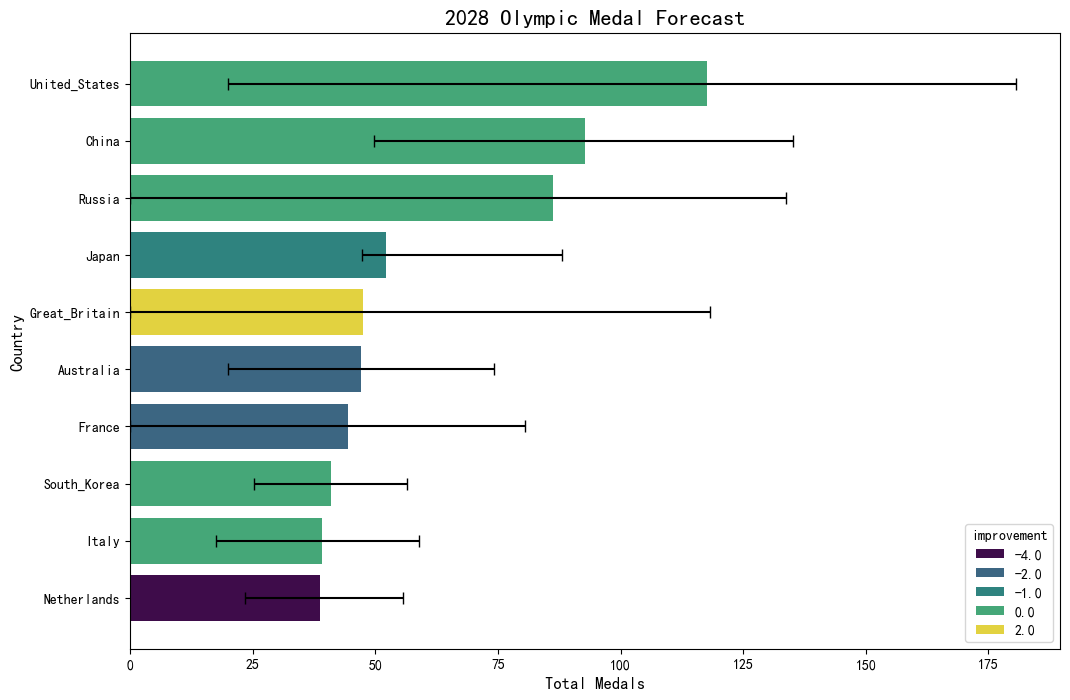

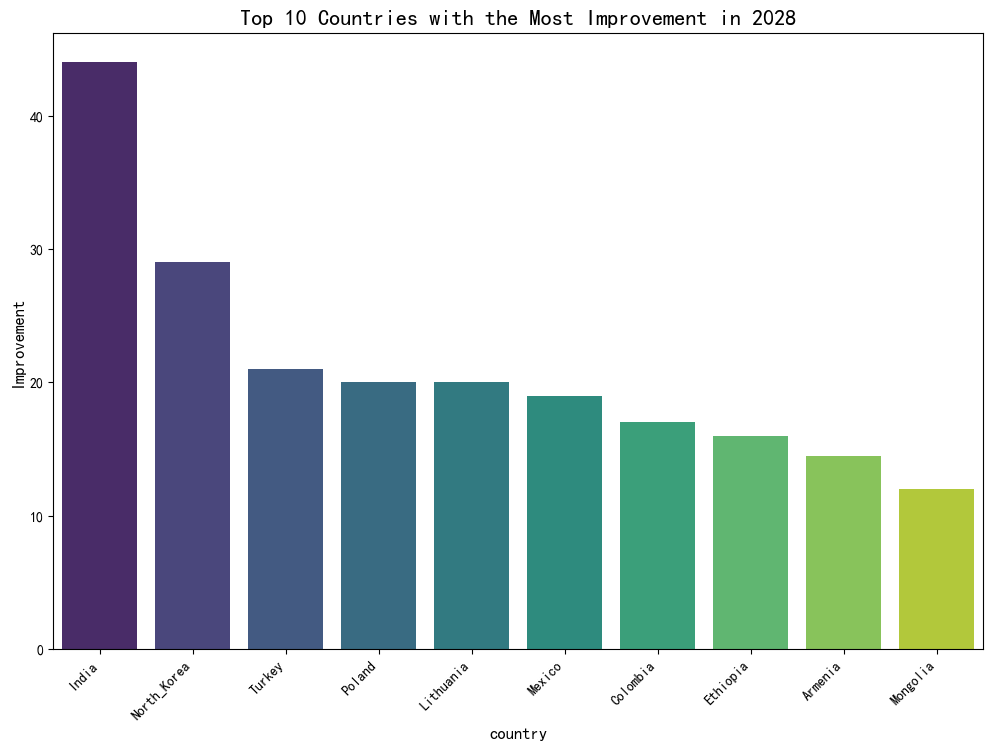

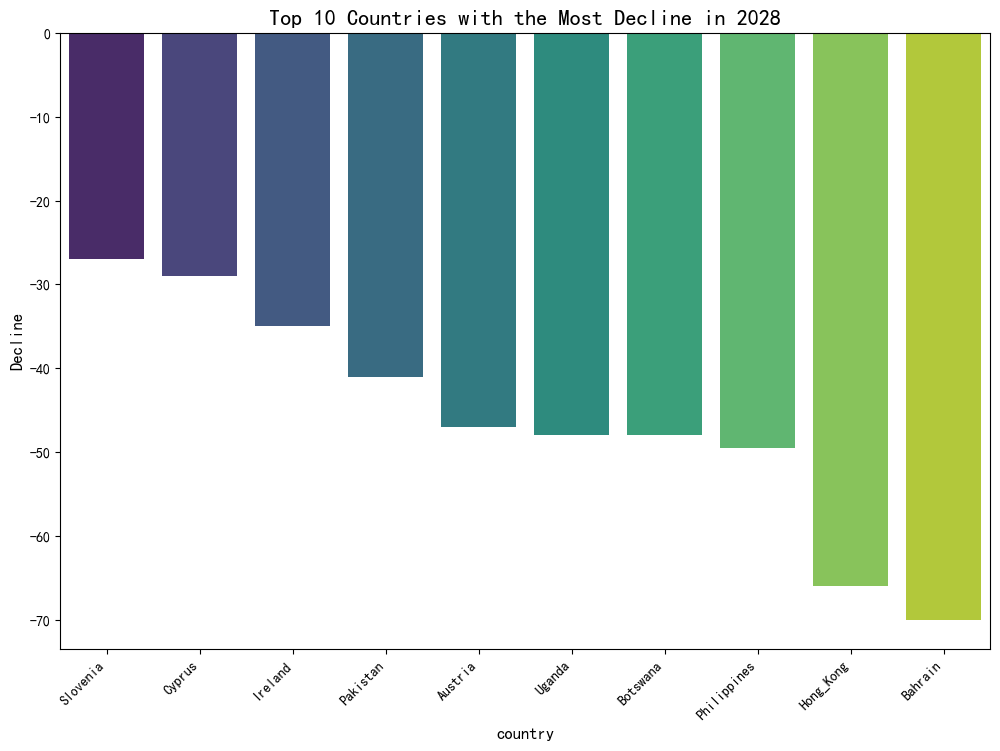

In [40]:
df_predict_1 = pd.read_csv('2028_olympic_forecast11.csv')


plt.figure(figsize=(12, 8))
sns.barplot(x='Total', y='country', data=df_predict_1.head(10), palette='viridis', hue='improvement', dodge=False)
plt.errorbar(x=df_predict_1.head(10)['Total'], y=df_predict_1.head(10).head(10)['country'], 
             xerr=[df_predict_1.head(10)['Total'] - df_predict_1.head(10)['Total_lower'], df_predict_1.head(10)['Total_upper'] - df_predict_1.head(10)['Total']],
             fmt='none', c='black', capsize=4)
plt.title('2028 Olympic Medal Forecast', fontsize=16)
plt.xlabel('Total Medals', fontsize=12)
plt.ylabel('Country', fontsize=12)



## 选择进步名次最多的前10个国家，和退步名次最多的前10个国家
# 进步名次最多的前10个国家
df_predict_1 = df_predict_1.sort_values('improvement', ascending=False)
top_10_improvement = df_predict_1[['country', 'improvement']].head(10)
top_10_decline = df_predict_1[['country', 'improvement']].tail(10)


# Progress and decline plots
plt.figure(figsize=(12, 8))
sns.barplot(y='improvement', x='country', data=top_10_improvement, palette='viridis')
plt.title('Top 10 Countries with the Most Improvement in 2028', fontsize=16)
plt.ylabel('Improvement', fontsize=12)
plt.xlabel('country', fontsize=12)
plt.xticks(rotation=45, ha='right')

plt.figure(figsize=(12, 8))
sns.barplot(y='improvement', x='country', data=top_10_decline, palette='viridis')
plt.title('Top 10 Countries with the Most Decline in 2028', fontsize=16)
plt.ylabel('Decline', fontsize=12)
plt.xlabel('country', fontsize=12)
plt.xticks(rotation=45, ha='right')

plt.show()
